In [1]:
!echo "Last updated: `date`"

Last updated: Wed Jul 29 16:59:13 PDT 2020


Resources:
- https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcessRegressionModel
- https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcess

In [2]:
# Import libraries.
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb

# Alias.
ExponentiatedQuadratic = tfp.math.psd_kernels.ExponentiatedQuadratic

import sys
sys.path.append('../util')
import gp_plot_util

# Default data type for tensorflow tensors.
dtype = np.float64

# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

# Set number of cores.
# tf.config.threading.set_inter_op_parallelism_threads(4)

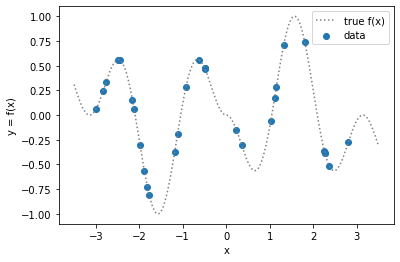

In [3]:
# Read data.
path_to_data = '../data/gp-data-N30.json'
simdata = json.load(open(path_to_data))

# Plot data and true function.
plt.scatter(simdata['x'], simdata['f'], label='data')
plt.plot(simdata['x_true'], simdata['f_true'], ls=':', c='grey', label='true f(x)')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend();

# Store data as torch.tensors.
X = np.array(simdata['x'])
y = np.array(simdata['f'])
x_true = np.array(simdata['x_true'])
f_true = np.array(simdata['f_true'])

Here we will use the squared exponential covariance function:

$$
\alpha^2 \cdot \exp\left\{-\frac{d^2}{2\rho^2}\right\}
$$

where $\alpha$ is the amplitude of the covariance, $\rho$ is the length scale which controls how slowly information decays with distance (larger $\rho$ means information about a point can be used for data far away); and $d$ is the distance.

In [4]:
# Specify GP model
gp_model = tfd.JointDistributionNamed(dict(
    amplitude=tfd.LogNormal(dtype(0), dtype(1)),  # amplitude
    length_scale=tfd.LogNormal(dtype(-2), dtype(0.1)),  # length scale
    obs=lambda length_scale, amplitude: tfd.GaussianProcess(
          kernel=tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale),
          index_points=X[..., np.newaxis],
          observation_noise_variance=dtype(0), jitter=1e-3)
))

# Run graph to make sure it works.
_ = gp_model.sample()

# Initial values.
initial_state = [
    1e-1 * tf.ones([], dtype=np.float64, name='amplitude'),
    1e-1 * tf.ones([], dtype=np.float64, name='length_scale')
]

# Bijectors (from unconstrained to constrained space)
bijectors = [
    tfp.bijectors.Softplus(),  # amplitude
    tfp.bijectors.Softplus()  # length_scale
]

# Unnormalized log posterior
def unnormalized_log_posterior(amplitude, length_scale):
    return gp_model.log_prob(amplitude=amplitude, length_scale=length_scale, obs=y)

In [5]:
# @tf.function(autograph=False, experimental_compile=True)  # Slower?
@tf.function(autograph=False)
def run_hmc(num_results, num_burnin_steps):
      return tfp.mcmc.sample_chain(
          seed=1,
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state=initial_state,
          kernel=tfp.mcmc.SimpleStepSizeAdaptation(
              tfp.mcmc.TransformedTransitionKernel(
                  inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                      target_log_prob_fn=unnormalized_log_posterior,
                      step_size=0.01,
                      num_leapfrog_steps=100),
                  bijector=bijectors),
          num_adaptation_steps=num_burnin_steps),
          trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

In [6]:
# Compile
%time [amplitudes, length_scales], is_accepted = run_hmc(2, 2)
%time [amplitudes, length_scales], is_accepted = run_hmc(2, 2)

# Run
%time [amplitudes, length_scales], is_accepted = run_hmc(1000, 1000)

# Print acceptance rate.
print("Acceptance rate: {}".format(np.mean(is_accepted)))

# Collect posterior samples.
hmc_samples = dict(alpha=amplitudes.numpy(), rho=length_scales.numpy())

Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
CPU times: user 2.13 s, sys: 135 ms, total: 2.27 s
Wall time: 2.05 s
CPU times: user 281 ms, sys: 63.3 ms, total: 344 ms
Wall time: 126 ms
CPU times: user 2min 11s, sys: 24.9 s, total: 2min 36s
Wall time: 1min 1s
Acceptance rate: 0.205


In [7]:
# @tf.function(autograph=False)
# @tf.function(autograph=False, experimental_compile=True)  # Slower?
@tfp.experimental.nn.util.tfcompile
def run_nuts(num_results, num_burnin_steps):
      return tfp.mcmc.sample_chain(
          seed=1,
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state=initial_state,
          kernel=tfp.mcmc.SimpleStepSizeAdaptation(
              tfp.mcmc.TransformedTransitionKernel(
                  inner_kernel = tfp.mcmc.NoUTurnSampler(
                      target_log_prob_fn=unnormalized_log_posterior,
                      max_tree_depth=10, step_size=0.1),
                  bijector=bijectors),
          num_adaptation_steps=num_burnin_steps,
          target_accept_prob=0.8),
          trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

In [8]:
# Compile
%time [amplitudes, length_scales], is_accepted = run_nuts(2, 2)
%time [amplitudes, length_scales], is_accepted = run_nuts(2, 2)
# Run
%time [amplitudes, length_scales], is_accepted = run_nuts(1000, 1000)
# Print acceptance rate.
print("Acceptance rate: {}".format(np.mean(is_accepted)))
# Collect posterior samples.
nuts_samples = dict(alpha=amplitudes.numpy(), rho=length_scales.numpy())

Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
CPU times: user 4.1 s, sys: 23.1 ms, total: 4.13 s
Wall time: 3.99 s
CPU times: user 44.5 ms, sys: 111 µs, total: 44.6 ms
Wall time: 14.8 ms
CPU times: user 19.7 s, sys: 1.49 s, total: 21.2 s
Wall time: 9.52 s
Acceptance rate: 0.816


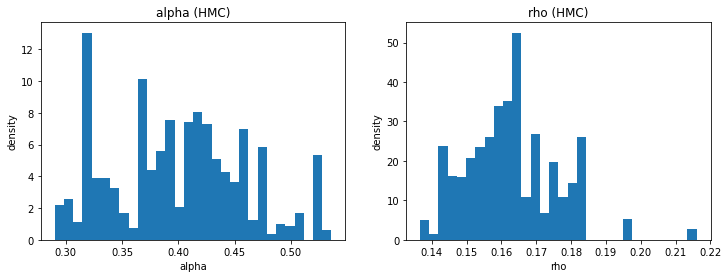

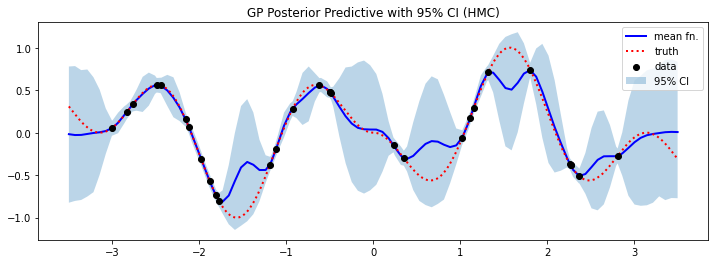

In [9]:
# Plot posterior for HMC
gp_plot_util.make_plots(hmc_samples, suffix="HMC",
                        x=np.array(simdata['x']), y=np.array(simdata['f']),
                        x_true=simdata['x_true'], f_true=simdata['f_true'])

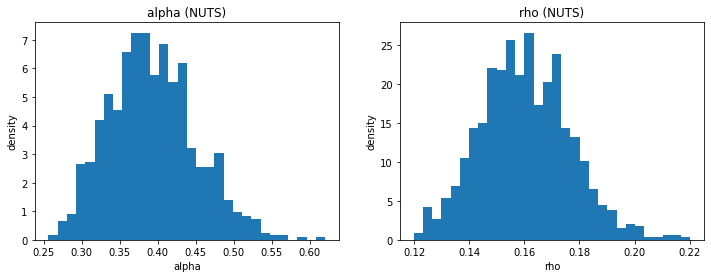

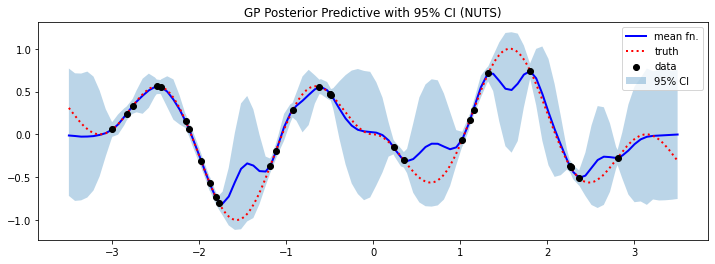

In [10]:
# Plot posterior for NUTS
gp_plot_util.make_plots(nuts_samples, suffix="NUTS",
                        x=np.array(simdata['x']), y=np.array(simdata['f']),
                        x_true=simdata['x_true'], f_true=simdata['f_true'])